<a href="https://colab.research.google.com/github/jihunyuk/Any/blob/main/23_02_07_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load the required libraries
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import easydict
from tqdm.notebook import trange, tqdm
from torch import optim
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import torch.nn.functional as F

drive.mount('/content/gdrive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# model parameters
timesteps = 60
sampling_frequency = 40
hidden_layer_units = 10
batch_size = 40000


Mounted at /content/gdrive


In [2]:
# -------------------------------------------- load data & pre-processing -------------------------------------------- #

# set this to the path of your data file
PPG_data_path = '/content/gdrive/MyDrive/20210828_KOHI_RNN_DAE-master/PPG_40Hz_10sec_25000set.txt'
PPG_data = np.loadtxt(PPG_data_path)

print(len(PPG_data))
print('The shape of the original dataset is %i by %i' % np.shape(PPG_data))  # (10000, 400) -> 10000 rows of 40Hz 10sec PPG data // (x, y) -> x : batch size
print('The shape of the %i timestep dataset is %i by %i' % (timesteps, int(np.ceil((400-timesteps)/timesteps)*len(PPG_data)), timesteps))

25000
The shape of the original dataset is 25000 by 400
The shape of the 60 timestep dataset is 150000 by 60


25000
(120000, 60)
(30000, 60)


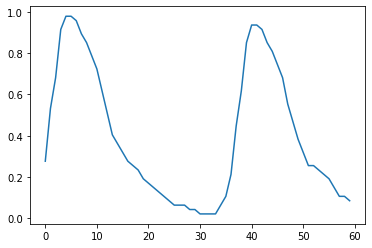

float32


In [3]:
train_input_data_list = []
train_output_data_list = []
val_input_data_list = []
val_output_data_list = []

print(len(PPG_data))
for datanum in range(len(PPG_data)):
  for index in range (0, 360, timesteps):
    data = PPG_data[datanum, index:index+timesteps].copy()
    if datanum < 0.8 * len(PPG_data):
      train_input_data_list.append(data)
    else:
      val_input_data_list.append(data)

train_input_data_list = np.asarray(train_input_data_list, dtype=np.float32)
val_input_data_list = np.asarray(val_input_data_list, dtype=np.float32)

print(np.shape(train_input_data_list)) #(120000, 60) => (batch_size, timesteps)
print(np.shape(val_input_data_list)) #(30000, 60) => (batch_size, timesteps)

plt.figure()
plt.plot(train_input_data_list[0,])
plt.show()
print(train_input_data_list[0,].dtype)

In [4]:
# if the deep learning model used here is recurrent, need to reshape the input data to match the keras LSTM input_shape
train_input_data_list = np.reshape(train_input_data_list, [len(train_input_data_list), timesteps, 1])
val_input_data_list = np.reshape(val_input_data_list, [len(val_input_data_list), timesteps, 1])

train_loader_AE = DataLoader(train_input_data_list, batch_size=batch_size, shuffle=True)
test_loader_AE = DataLoader(val_input_data_list, batch_size=batch_size, shuffle=True)

In [5]:
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                             bidirectional=False)
        

    def forward(self, x):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x)
        return (hidden, cell)

class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            bidirectional=False)        
        self.fc = nn.Linear(hidden_size, output_size)
   
        
    def forward(self, x, hidden):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        #prediction = output.view(40000, 60 ,1)
        return prediction, (hidden, cell)
       # return output, (hidden, cell)

'''
class RAE(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
      super(RAE, self).__init__()
      self.encoder = Encoder(input_size, hidden_size, num_layers)
      self.decoder = Decoder(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
      xh, xc = self.encoder(x)
      x, _ = self.decoder(xh)
      return x
'''

'\nclass RAE(nn.Module):\n\n    def __init__(self, input_size, hidden_size, output_size, num_layers):\n      super(RAE, self).__init__()\n      self.encoder = Encoder(input_size, hidden_size, num_layers)\n      self.decoder = Decoder(input_size, hidden_size, output_size, num_layers)\n\n    def forward(self, x):\n      xh, xc = self.encoder(x)\n      x, _ = self.decoder(xh)\n      return x\n'

In [6]:
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:

        super(LSTMAutoEncoder, self).__init__()
        # 1. hyper parameter
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1
        # 2. encoder, decoder setting
        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
    # 3. feed-forward
    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    # 4. calculate loss
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        '''
        recons = args[0].cpu().detach()
        input = args[1].cpu().detach()
        
        plt.figure()
        plt.plot(input[0,:,:])
        plt.plot(recons[0,:,:])
        plt.show()
        '''

        ## MSE loss(Mean squared Error)
        loss =F.mse_loss(recons, input)
        return loss

In [7]:
def run(args, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## iteration
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## training
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

In [8]:
args = easydict.EasyDict({
    "batch_size": 40000, ## batch_size
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU utility
    "input_size": 1, ## input dimension
    "latent_size": 10, ## Hidden layer dimension
    "output_size": 1, ## output dimention
    "window_size" : 60, ## sequence Length
    "num_layers": 1,     ## number of LSTM layer
    "learning_rate" : 0.001, ## learning rate
    "max_iter" : 100000, ## Iteration
    'early_stop' : True,  ## early stop
})

In [9]:
model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 10, batch_first=True)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(1, 10, batch_first=True)
    (fc): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [10]:
model = run(args, model, train_loader_AE, test_loader_AE)

  0%|          | 0/33334 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

early stop condition   best_loss[0.0774264931678772]  eval_loss[0.07774940133094788]


TypeError: ignored

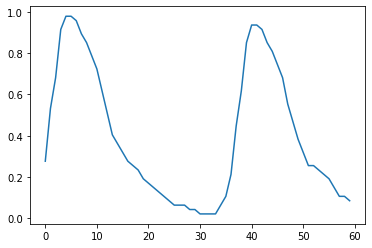

In [21]:
# plotting 해볼것 너무 빨리 됐어
plt.figure()
plt.plot(train_input_data_list[0,])
single_prediction = model(train_input_data_list[0,])
print(single_prediction)
plt.plot()
plt.show()

In [22]:
# Start training

model_AE = RAE(input_size=1, hidden_size=10, output_size=1, num_layers=1)
model_AE = model_AE.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_AE.parameters(), lr=1)
model_AE.train()

NameError: ignored

In [23]:
train(model_AE, train_loader_AE, optimizer, 5)

NameError: ignored